libraries

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline
import sklearn.linear_model as linmodels

from itertools import chain, combinations

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import optimizers

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model

from sklearn.model_selection import train_test_split

data generator

In [ ]:
# create some data

covdim = 2

# def X_samp(n):
#   x1 = np.vstack((2*np.random.randn(n, 2) -3, np.random.randn(n, 2) ))
#   #x2 = np.vstack((2*np.random.randn(n, 2)+5, np.random.randn(n, 2) -6))
#   #X = np.vstack((x1, x2)) 
#   return x1

def X_samp(n):
  return np.random.rand(n,2)

def true1(x):
  #return x[0]**2 + x[1]**2
  return 2*x[0]

def true2(x):
  return x[0]*x[1]

def true3(x):
  if x[0] < 0.6:
    return x[1]**2
  elif x[1] > 0.4:
    return 2*x[1]
  else:
    return x[0] - x[1]

def true4(x):
  if x[0] < 0.6:
    return x[1]**2 - x[0]
  elif x[1] > 0.4:
    return 2*x[1]*x[0]
  else:
    return x[0] - x[1]

true_func = true4

shap function

In [ ]:
# shap function

def shap(model, covdim, covdist_sampler, covval, ind, M=10000):

  j = ind-1

  def shapwt(i):
    if i == covdim:
      return 0
    else:
      return math.factorial(i) * math.factorial(covdim - i - 1) / math.factorial(covdim)

  subsets = [[]]

  for el in range(covdim):
    subsets += [s+[el] for s in subsets]

  subsets.pop()

  shap_val = 0
  for subset in subsets:
    model_diff = 0
    for _ in range(M):
      covsamp = covdist_sampler(1)[0]
      covsamp_withj = np.array([covval[k] if k==j or k in subset else covsamp[k] for k in range(covdim)])
      covsamp_noj = np.array([covval[k] if k in subset else covsamp[k] for k in range(covdim)])
      model_diff += model(covsamp_withj) - model(covsamp_noj)
    
    shap_val += shapwt(len(subset)) * model_diff / M

  return shap_val

debug for shap values

In [ ]:
#@title
# debug tests for shap value

###
# shap(x) = x - 1/2
# def model(x):
#   return x

# covdim = 1
# ind = 1

# def covdist_sampler():
#   return np.random.rand(1)

# covval = np.array([0.2])

# shap(model,covdim,covdist_sampler,covval,ind)

###
# shap(x) = x**2 - 1
# def model(x):
#   return x**2

# covdim = 1
# ind = 1

# def covdist_sampler():
#   return np.random.randn(1)

# covval = np.array([4])

# shap(model,covdim,covdist_sampler,covval,ind)

###
# shap(x) = (2x[0]-1, -x[1]+1/2)
# def model(x):
#   return 2*x[0] - x[1]

# covdim = 2
# ind = 2

# def covdist_sampler():
#   return np.random.rand(2)

# covval = np.array([1,1])

# shap(model,covdim,covdist_sampler,covval,ind)

###
# shap(x,1) = 0.5 * (x1^2 + x2^2)/2 + max(x1,x2) - 2/3
# def model(x):
#   return np.max(x)

# covdim = 2
# ind = 1

# def covdist_sampler():
#   return np.random.rand(2)

# covval = np.array([0,1])

# shap(model,covdim,covdist_sampler,covval,ind)

###

def f1(x):
  return x**2

def f2(x):
  return x - x**3

def test(x):
  x1,x2 = x
  return f1(x1) + f2(x2)

def f3(x):
  return np.max(x)

#print(shap(f1,1,lambda n: X_samp(1)[:,0].reshape((1,1)),np.array([0.4]),1,M=1000))
#print(shap(f2,1,lambda n: X_samp(1)[:,1].reshape((1,1)),np.array([0.6]),1,M=1000))
print(shap(f3,2,lambda n: X_samp(2),np.array([0,0.5]),1,M=1000))
#print(shap(test,2,X_samp,np.array([0.4, 0.6]),2,M=1000))

-0.13746544425463053


In [ ]:
X_samp(1)

array([[0.11339957, 0.63803369]])

neural net

In [ ]:
# train a model 

def fit_multilayer_nn(x, y, nodes_per_layer = 5, num_layers=3, batch_size=10000, epochs=100):

  model = Sequential()
  input_dim = len(x[0])
  print('input dimension: %s ' % input_dim)
  if isinstance(nodes_per_layer, list):
    assert(num_layers == len(nodes_per_layer))
  else:
    nodes_per_layer = [nodes_per_layer]*num_layers

  model.add(Dense(nodes_per_layer[0], input_dim=input_dim, name='input_mapping')) #, activation="tanh"))

  for l in range(num_layers-1):
    #model.add(Dense(nodes_per_layer, activation="relu"))
    model.add(Dense(nodes_per_layer[l+1], activation="relu", name='relu%s' % (l)))
    model.add(Dense(nodes_per_layer[l+1], name='fc%s' % (l))) #, activation="tanh"))


  # All parameter gradients will be clipped to
  # a maximum norm of 5.
  
  initial_learning_rate = 0.1
  lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=epochs/10,
    decay_rate=0.96,
    staircase=True)

  sgd = optimizers.SGD(learning_rate=lr_schedule, clipnorm=5.)
  #sgd = optimizers.SGD(lr=0.01, clipnorm=5.)
  model.add(Dense(1, name='final'));
  model.compile(loss='mean_squared_error', optimizer=sgd, metrics = ['mean_squared_error'])
  input_x = x.reshape(x.shape[0], -1)
  print(input_x.shape, y.shape)
  model.summary()
  callback_funs = None

  model.fit(input_x, y, batch_size=batch_size, epochs=epochs,
            verbose=2, validation_split=0.1, 
            validation_data=None, shuffle=True, class_weight=None, sample_weight=None, 
            initial_epoch=0, callbacks=callback_funs)

  return model


train neural net

In [ ]:
# run

def train_nn(X_sampler, true_model, num_samples=100, nodes_per_layer=[5]*3, batch_size=10, epochs=300):

  X = X_sampler(num_samples)
  y = np.array([true_model(x) for x in X])  

  test_size = 0.3
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

  num_layers = len(nodes_per_layer)
  model = fit_multilayer_nn(X_train, y_train, nodes_per_layer=nodes_per_layer, num_layers=num_layers, batch_size=batch_size, epochs=epochs)

  return model, X_train, X_test, y_train, y_test

model, X_train, X_test, y_train, y_test = train_nn(X_samp, true_func, num_samples=500, nodes_per_layer=[100]*3, epochs=200)

input dimension: 2 
(350, 2) (350,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_mapping (Dense)       (None, 100)               300       
                                                                 
 relu0 (Dense)               (None, 100)               10100     
                                                                 
 fc0 (Dense)                 (None, 100)               10100     
                                                                 
 relu1 (Dense)               (None, 100)               10100     
                                                                 
 fc1 (Dense)                 (None, 100)               10100     
                                                                 
 final (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,801

explore model performance

In [ ]:
x = X_test

ind = 1

print(x[ind])
print(true_func(x[ind]))
print(model.predict(np.array([x[ind]])))


[0.88073964 0.56136414]
1.1227282791183097
[[1.1691123]]


/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_cpu_blairbilodeau.kernel.blairbilodeau.5202848438595.14b334fb3717c109/mount/server/ml_notebook.runfiles/google3/third_party/py/keras/engine/training_v1.py:2352: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


1/1 [==============================] - 0s 134ms/step


Text(0.5, 1.0, 'vary x1, x2=0.3')

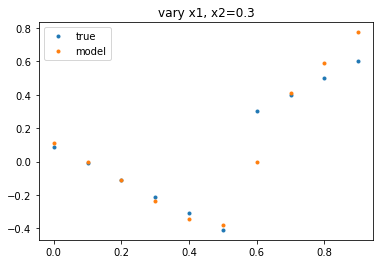

In [ ]:
x = np.array([0.7,0.3])

x1_vary = np.array([[u,x[1]] for u in np.arange(0.0, 1.0, 0.1)])
true_x1_vary = np.array([true_func(z) for z in x1_vary])
model_x1_vary = model.predict(x1_vary)

plt.plot(x1_vary[:,0], true_x1_vary, '.')
plt.plot(x1_vary[:,0], model_x1_vary, '.')
plt.legend(['true', 'model'])
plt.title("vary x1, x2={xval}".format(xval = x[1]))

# x2_vary = np.array([[x[0],u] for u in np.arange(0.0, 1.0, 0.1)])
# true_x2_vary = np.array([true_func(z) for z in x2_vary])
# model_x2_vary = model.predict(x2_vary)


# plt.plot(x2_vary[:,1], true_x2_vary, '.')
# plt.plot(x2_vary[:,1], model_x2_vary, '.')
# plt.legend(['true', 'model'])
# plt.title("vary x2, x1={xval}".format(xval = x[0]))


evaluate model shap vs true shap

In [ ]:
def shap_model(x):
  return model.predict(np.array([x]), verbose=0)[0]

covval = np.array([0.7,0.5])
ind = 2

print(shap(true_func, 2, X_samp, covval, ind, M=100))
print(shap(shap_model, 2, X_samp, covval, ind, M=100))


-0.1101790561161919
[-0.12341885]


construct counterexample that matches model on training data, has free params in local neighbourhood, and then eval test error
(for now just gonna hardcode 2 dims, will make work for more later)

In [ ]:
# number of datapoints we have
X_train_small = X_train[0:5]
n_train = len(X_train_small)

# example to match phi on
# hardcoded in for prototyping
#covval_ind = np.random.randint(n_train,size=1)
#covval = X_train[covval_ind][0]
covval = np.array([0.3,0.8])
#delta = 0.05 # this can't go outside domain

# phi values to match
expval1 = shap(shap_model, 2, X_samp, covval, 1, M=100)
expval2 = shap(shap_model, 2, X_samp, covval, 2, M=100)

# FREE PARAMS
# fix these to whatever you want
deriv_val1 = np.array([0.1])
deriv_val2 = np.array([-0.1])

# n constraints for training data points (only use covval from training data) -- assume n is odd
# 2 constraints for expvals
# if each polynomial is degree d, then we have 2d+1 parameters -- only x1 gets intercept
# want 2d+1 = n+4 (match all constraints, plus extra free dimension for each feature)
# d = (n+3)/2
degree = int((n_train+3)/2)

model_y = model.predict(X_train_small).reshape((n_train,))
values = np.append(model_y,[expval1,expval2,deriv_val1,deriv_val2]).reshape((n_train+4,1))

# powers of training values
X_train_pows1 = np.array([[x[0]**j for j in range(1,degree+1)] for x in X_train_small])
X_train_pows2 = np.array([[x[1]**j for j in range(1,degree+1)] for x in X_train_small])
X_train_pows = np.hstack((np.ones((n_train, 1)), X_train_pows1, X_train_pows2)) # [1, x1, x1**2, ..., x1**d, x2, x2**2, ..., x2**d]

# approximate moments to control expvals
# NOT assuming independence
# shift them by xval (because using to compute phi)
num_per_deg = 1000
moment_samps = X_samp(num_per_deg*degree)
moments1 = np.array([covval[0]**j - np.mean(moment_samps[:,0]**j) for j in range(1,degree+1)]).reshape((1,degree))
moments2 = np.array([[covval[1]**j - np.mean(moment_samps[:,1]**j) for j in range(1,degree+1)]]).reshape((1,degree))
moments1 = np.hstack((np.zeros((1, 1)), moments1, np.zeros((1, degree)))) # [0, x1-Ex1, x1**2-Ex1**2, ..., x1**d-Ex1**d, 0, 0, 0, ..., 0]
moments2 = np.hstack((np.zeros((1, degree+1)), moments2)) # [0, 0, 0, ..., 0, 0, x2-Ex2, x2**2-Ex2**2, ..., x2**d-Ex2**d]

# derivatives at covval
derivs1 = np.array([j*(covval[0]**(j-1)) for j in range(1,degree+1)]).reshape(1,degree)
derivs2 = np.array([j*(covval[1]**(j-1)) for j in range(1,degree+1)]).reshape(1,degree)
derivs1 = np.hstack((np.zeros((1, 1)), derivs1, np.zeros((1, degree)))) # [0, 1, 2*x1, ..., d*x1**(d-1), 0, 0, 0, ..., 0]
derivs2 = np.hstack((np.zeros((1, degree+1)), derivs2)) # [0, 0, 0, ..., 0, 1, 2*x2, ..., d*x2**(d-1)]

constraints = np.vstack((X_train_pows, moments1, moments2, derivs1, derivs2))
# print(X_train_pows.shape)
# print(moments1.shape)
# print(moments2.shape)
# print(derivs1.shape)
# print(derivs2.shape)
# print(constraints.shape)
# print(values.shape)
# print(degree)
# print(n_train)

### very ill-conditioned
params = np.linalg.solve(constraints,values).reshape((2*degree+1,))
#print(params)

def counterexample(x):
  x1, x2 = x

  val = 0
  for j in range(degree+1):
    val += params[j] * (x1**(j))
  for k in range(degree+1,2*degree+1):
    val += params[k] * (x2**(k-degree))

  return val

1/1 [==============================] - 0s 24ms/step


sanity check

In [ ]:
print(np.dot(constraints,params)[0:5])
print(values[0:5])
print(params[0:5])

[ 1.53914143  1.5673294   1.2794562  -0.16591332  0.72697387]
[[ 1.55236363]
 [ 1.45061731]
 [ 1.44459224]
 [-0.01758945]
 [ 0.53961241]]
[ -0.40737675   2.56632691 -20.10111368  53.5516584  -52.5114704 ]


compare performance visually

Text(0.5, 1.0, 'vary x1, x2=0.12582125418280965')

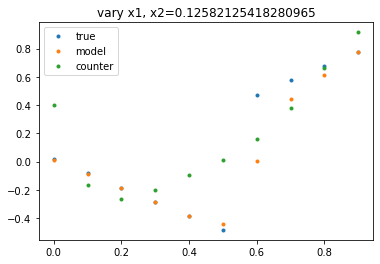

In [ ]:
x = X_train_small[1]

x1_vary = np.array([[u,x[1]] for u in np.arange(0.0, 1.0, 0.1)])
x1_vary
true_x1_vary = np.array([true_func(z) for z in x1_vary])
model_x1_vary = model.predict(x1_vary)
counter_x1_vary = np.array([counterexample(z) for z in x1_vary])
#counter_x1_vary

plt.plot(x1_vary[:,0], true_x1_vary, '.')
plt.plot(x1_vary[:,0], model_x1_vary, '.')
plt.plot(x1_vary[:,0], counter_x1_vary, '.')
plt.legend(['true', 'model', 'counter'])
plt.title("vary x1, x2={xval}".format(xval = x[1]))

# x2_vary = np.array([[x[0],u] for u in np.arange(0.0, 1.0, 0.1)])
# true_x2_vary = np.array([true_func(z) for z in x2_vary])
# model_x2_vary = model.predict(x2_vary)


# plt.plot(x2_vary[:,1], true_x2_vary, '.')
# plt.plot(x2_vary[:,1], model_x2_vary, '.')
# plt.legend(['true', 'model'])
# plt.title("vary x2, x1={xval}".format(xval = x[0]))

compare shap values

In [ ]:
ind = 2
print("true shap = {x}".format(x = round(shap(true_func, 2, X_samp, covval, ind, M=1000),4)))
print("model shap = {x}".format(x = round(shap(shap_model, 2, X_samp, covval, ind, M=1000)[0],3)))
print("counter shap = {x}".format(x = round(shap(counterexample, 2, X_samp, covval, ind, M=1000),4)))
#print(covval)
#X_train_small[1]

#covdist_sampler = lambda n: X_samp(1)[:,0].reshape((1,1))
#covdist_sampler(1)[0]

true shap = 0.3222
model shap = 0.3240000009536743
counter shap = 0.2877


compare accuracy

In [ ]:
model_train_err = np.mean(np.square(np.array([true_func(z) for z in X_train]).reshape((len(X_train),1)) - model.predict(X_train)))
print("model train error = {x}".format(x=round(model_train_err,4)))

counter_train_err = np.mean(np.square(np.array([true_func(z) for z in X_train]).reshape((len(X_train),1)) - np.array([counterexample(z) for z in X_train]).reshape((len(X_train),1))))
print("counter train error = {x}".format(x=round(counter_train_err,4)))

model_test_err = np.mean(np.square(np.array([true_func(z) for z in X_test]).reshape((len(X_test),1)) - model.predict(X_test)))
print("model test error = {x}".format(x=round(model_test_err,4)))

counter_test_err = np.mean(np.square(np.array([true_func(z) for z in X_test]).reshape((len(X_test),1)) - np.array([counterexample(z) for z in X_test]).reshape((len(X_test),1))))
print("counter test error = {x}".format(x=round(counter_test_err,4)))

model train error = 0.0097
counter train error = 0.0408
model test error = 0.0087
counter test error = 0.0408


where is the accuracy worst?

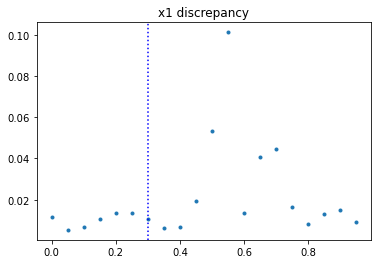

In [ ]:
#print(covval)

# how does the error change as you vary x1 (averaged over x2)
# expect to see it peak near covval[0]
def x1_discrepancy(x1):
  xvals = np.array([[x1,u] for u in np.arange(0,1,0.01)])
  return np.mean(np.square(np.array([counterexample(z) for z in xvals]).reshape((len(xvals),1)) - model.predict(xvals)))

def x2_discrepancy(x2):
  xvals = np.array([[u,x2] for u in np.arange(0,1,0.01)])
  return np.mean(np.square(np.array([counterexample(z) for z in xvals]).reshape((len(xvals),1)) - model.predict(xvals)))

x1vals = np.arange(0,1,0.05)
x1disc_vals = np.array([x1_discrepancy(x1) for x1 in x1vals])

plt.plot(x1vals, x1disc_vals, '.')
plt.title('x1 discrepancy')
plt.axvline(x = covval[0], color = 'b', ls=':')

#

# x2vals = np.arange(0,1,0.05)
# x2disc_vals = np.array([x2_discrepancy(x2) for x2 in x2vals])

# plt.plot(x2vals, x2disc_vals, '.')
# plt.title('x2 discrepancy')
# plt.axvline(x = covval[1], color = 'b', ls=':')

construct regularized least squares counterexample

In [ ]:
# number of datapoints we have
X_train_small = X_train
n_train = len(X_train_small)

# example to match phi on
# hardcoded in for prototyping
#covval_ind = np.random.randint(n_train,size=1)
#covval = X_train[covval_ind][0]
covval = np.array([0.3,0.8])

# phi values to match
expval1 = shap(shap_model, 2, X_samp, covval, 1, M=100)
expval2 = shap(shap_model, 2, X_samp, covval, 2, M=100)

# FREE PARAMS
# fix these to whatever you want
deriv_val1 = np.array([1])
deriv_val2 = np.array([-1])

# n constraints for training data points (only use covval from training data) -- assume n is odd
# 2 constraints for expvals
# if each polynomial is degree d, then we have 2d+1 parameters -- only x1 gets intercept
# want 2d+1 = n+4 (match all constraints, plus extra free dimension for each feature)
# d = (n+3)/2
#degree = int((n_train+3)/2)
degree = 5
reg_param = 1

model_y = model.predict(X_train_small).reshape((n_train,))
values = np.append(model_y,[reg_param*expval1,reg_param*expval2,reg_param*deriv_val1,reg_param*deriv_val2]).reshape((n_train+4,1))

# powers of training values
X_train_pows1 = np.array([[x[0]**j for j in range(1,degree+1)] for x in X_train_small])
X_train_pows2 = np.array([[x[1]**j for j in range(1,degree+1)] for x in X_train_small])
X_train_pows = np.hstack((np.ones((n_train, 1)), X_train_pows1, X_train_pows2)) # [1, x1, x1**2, ..., x1**d, x2, x2**2, ..., x2**d]

# approximate moments to control expvals
# NOT assuming independence
# shift them by xval (because using to compute phi)
num_per_deg = 1000
moment_samps = X_samp(num_per_deg*degree)
moments1 = np.array([covval[0]**j - np.mean(moment_samps[:,0]**j) for j in range(1,degree+1)]).reshape((1,degree))
moments2 = np.array([[covval[1]**j - np.mean(moment_samps[:,1]**j) for j in range(1,degree+1)]]).reshape((1,degree))
moments1 = np.hstack((np.zeros((1, 1)), moments1, np.zeros((1, degree)))) # [0, x1-Ex1, x1**2-Ex1**2, ..., x1**d-Ex1**d, 0, 0, 0, ..., 0]
moments2 = np.hstack((np.zeros((1, degree+1)), moments2)) # [0, 0, 0, ..., 0, 0, x2-Ex2, x2**2-Ex2**2, ..., x2**d-Ex2**d]

# derivatives at covval
derivs1 = np.array([j*(covval[0]**(j-1)) for j in range(1,degree+1)]).reshape(1,degree)
derivs2 = np.array([j*(covval[1]**(j-1)) for j in range(1,degree+1)]).reshape(1,degree)
derivs1 = np.hstack((np.zeros((1, 1)), derivs1, np.zeros((1, degree)))) # [0, 1, 2*x1, ..., d*x1**(d-1), 0, 0, 0, ..., 0]
derivs2 = np.hstack((np.zeros((1, degree+1)), derivs2)) # [0, 0, 0, ..., 0, 1, 2*x2, ..., d*x2**(d-1)]

constraints = np.vstack((X_train_pows, reg_param*moments1, reg_param*moments2, reg_param*derivs1, reg_param*derivs2))
print(X_train_pows.shape)
print(moments1.shape)
print(moments2.shape)
print(derivs1.shape)
print(derivs2.shape)
print(constraints.shape)
# print(values.shape)
# print(degree)
# print(n_train)

### solve least squares
params = np.linalg.lstsq(constraints,values,rcond=None)[0].reshape((2*degree+1,))
print(params)

def counterexample(x):
  x1, x2 = x

  val = 0
  for j in range(degree+1):
    val += params[j] * (x1**(j))
  for k in range(degree+1,2*degree+1):
    val += params[k] * (x2**(k-degree))

  return val

11/11 [==============================] - 0s 1ms/step
(350, 11)
(1, 11)
(1, 11)
(1, 11)
(1, 11)
(354, 11)
[-2.34482069e-02 -3.61782578e+00  1.24504651e+01 -2.96936500e+01
  4.33800315e+01 -2.18226735e+01  4.39908474e+00 -3.33003893e+01
  9.75551265e+01 -1.13655883e+02  4.61985449e+01]


visualize gradient difference

1/1 [==============================] - 0s 33ms/step


Text(0.5, 1.0, 'vary x1, x2=0.8')

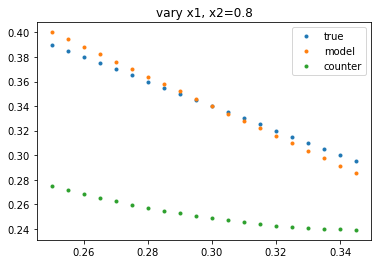

In [ ]:
delta = 0.05

x = covval
x1,x2 = x

x1_vary = np.array([[u,x[1]] for u in np.arange(x1-delta, x1+delta, delta/10)])
x1_vary
true_x1_vary = np.array([true_func(z) for z in x1_vary])
model_x1_vary = model.predict(x1_vary)
counter_x1_vary = np.array([counterexample(z) for z in x1_vary])

plt.plot(x1_vary[:,0], true_x1_vary, '.')
plt.plot(x1_vary[:,0], model_x1_vary, '.')
plt.plot(x1_vary[:,0], counter_x1_vary, '.')
plt.legend(['true', 'model', 'counter'])
plt.title("vary x1, x2={xval}".format(xval = x[1]))

# x2_vary = np.array([[x[0],u] for u in np.arange(x2-delta, x2+delta, delta/10)])
# true_x2_vary = np.array([true_func(z) for z in x2_vary])
# model_x2_vary = model.predict(x2_vary)
# counter_x2_vary = np.array([counterexample(z) for z in x2_vary])


# plt.plot(x2_vary[:,1], true_x2_vary, '.')
# plt.plot(x2_vary[:,1], model_x2_vary, '.')
# plt.plot(x2_vary[:,1], counter_x2_vary, '.')
# plt.legend(['true', 'model', 'counter'])
# plt.title("vary x2, x1={xval}".format(xval = x[0]))